## Modeling
This notebook contains modeling code for predicting smoke estimates from 2025-2050.

## Import Libraries

In [31]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Load in the data

In [32]:
yearly_smoke_estimate_df = pd.read_csv("../data_clean/norman_wildfires_SI_yearly_average.csv")
yearly_smoke_estimate_df = yearly_smoke_estimate_df[['Year', 'Smoke_Estimate']]
yearly_smoke_estimate_df.set_index('Year', inplace=True)
yearly_smoke_estimate_df.drop(yearly_smoke_estimate_df.tail(0).index, inplace = True)

## Fit the Model
For this analysis, I've chosen to use the [Holt-Winters](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html) Exponential Smoothing method to model the data and extrapolate out for the next 25 years. The Exponential Smoothing method provides a good balance of simplicity while still being able to capture the overall trends, by applying exponentially decreasing weighting to past observations but also incorporating smoothing to account for the high volatility. This method was suggested to me by fellow student Jake Flynn.

Note that there are serious drawbacks to this modeling exercise: first and foremost, as we see in the raw data, the data is quite noisy, especially in recent years. Additionally, performing any sort of forecasting always comes with a large amount of uncertainty, as we are attempting to predict beyond the domain of our training data. All in all, this model appear to give reasonable results, capturing the general trend of increasing smoke.

c:\Users\ajnet\anaconda3\envs\DATA557\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajnet\anaconda3\envs\DATA557\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ajnet\anaconda3\envs\DATA557\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


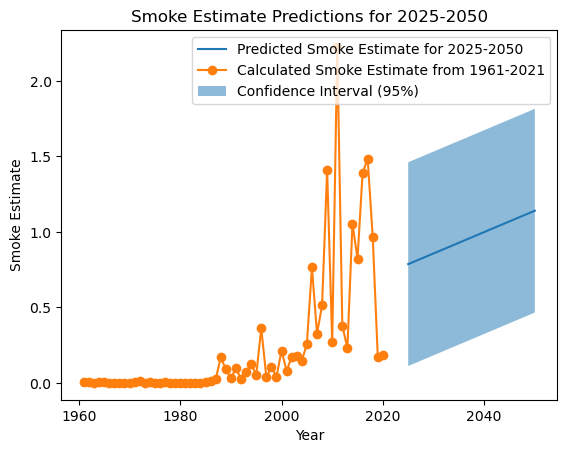

In [33]:
# Instatiate the model and fit it
holt_winters_model = ExponentialSmoothing(yearly_smoke_estimate_df['Smoke_Estimate'], trend="add") #The overall trend is additive, so we put that here # TODO update this
holt_winters_fit = holt_winters_model.fit()

# Use this to predict out from 2025-2050
future_years = list(range(2025, 2051))
predictions = holt_winters_fit.forecast(steps=26)
predictions_df = pd.DataFrame({'Year': future_years, 'Smoke_Estimate': predictions})

#Lastly, to get a sense of uncertainty, we can use the std of the residuals to build a 95% confidence interval
#Note that we are not accounting for the fact the there is likely more uncertainty about prediction further in the future, but rather are taking the uncertainty from all the previous datapoints
errors = 1.96 * np.std(holt_winters_fit.resid)
upper_bound = predictions + errors
lower_bound = predictions - errors
predictions_df['Upper_bound'] = upper_bound
predictions_df['Lower_bound'] = lower_bound

plt.plot(predictions_df['Year'], predictions_df['Smoke_Estimate'], label='Predicted Smoke Estimate for 2025-2050')
plt.plot(yearly_smoke_estimate_df.index, yearly_smoke_estimate_df['Smoke_Estimate'], marker = 'o', label='Calculated Smoke Estimate from 1961-2021')
plt.fill_between(predictions_df['Year'], predictions_df['Upper_bound'], predictions_df['Lower_bound'], alpha=0.5, label='Confidence Interval (95%)')
plt.title(f"Smoke Estimate Predictions for 2025-2050")
plt.xlabel("Year")
plt.ylabel(f"Smoke Estimate")
plt.legend()
plt.show()

In [35]:
predictions_df.to_csv("../data_clean/forecasted_smoke_estimate.csv")